In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pulp
import sys
import os
import importlib.util
import importlib
import gurobipy as gp

# モジュールを強制的に再ロード（古いキャッシュをクリア）
if 'code' in sys.modules:
    del sys.modules['code']
# サブモジュールも削除
for module_name in list(sys.modules.keys()):
    if module_name.startswith('code.'):
        del sys.modules[module_name]

current_dir = os.getcwd()
spec = importlib.util.spec_from_file_location("code", os.path.join(current_dir, "code", "__init__.py"))
code_module = importlib.util.module_from_spec(spec)
sys.modules["code"] = code_module
spec.loader.exec_module(code_module)

# サブモジュールも再ロード
importlib.reload(code_module)

make_tensor_grid_2d = code_module.make_tensor_grid_2d
make_tensor_grid_3d = code_module.make_tensor_grid_3d
product_beta_density = code_module.product_beta_density
solve_mechanism_symmetry_2agents = code_module.solve_mechanism_symmetry_2agents
solve_mechanism_symmetry_2agents_iterative = code_module.solve_mechanism_symmetry_2agents_iterative
save_results_symmetry_2agents = code_module.save_results_symmetry_2agents
load_results_symmetry_2agents = code_module.load_results_symmetry_2agents

print("モジュールを再ロードしました")


モジュールを再ロードしました


In [6]:
home_license = os.path.expanduser('~/gurobi.lic')
os.environ['GRB_LICENSE_FILE'] = home_license

SOLVER = pulp.GUROBI(msg=True)


# ケース1: 2人2財（対称性制約あり、シナジーなし）


In [7]:
# ケース1: 財a, 財bはBeta(1,1)
# 対称性制約のため、参加者1と参加者2は同じpointsとweightsを使用
NX, NY = 25, 25
BETA_PARAMS = [
    (1.0, 1.0),
    (1.0, 1.0),
]

points1, weights1 = make_tensor_grid_2d(NX, NY, BETA_PARAMS)
points2, weights2 = points1.copy(), weights1.copy()


In [ ]:
status, obj_val, u1_sol, u2_sol, p1_sol, p2_sol, n_iter = solve_mechanism_symmetry_2agents_iterative(
    points1, weights1, (NX, NY),
    solver=SOLVER
)

print("LP status:", status)
print("Optimal revenue:", obj_val)
print(f"Number of iterations: {n_iter}")

# 結果を保存
filepath_case1 = save_results_symmetry_2agents(
    points1, weights1,
    u1_sol, u2_sol, p1_sol, p2_sol,
    obj_val, status,
    grid_sizes1=(NX, NY),
    n_iter=n_iter,
    filename="results_symmetry_case1.npz"
)


Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2749041
Academic license 2749041 - for non-commercial use only - registered to ko___@u.northwestern.edu
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.1.0 25B78)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Academic license 2749041 - for non-commercial use only - registered to ko___@u.northwestern.edu
Optimize a model with 2000 rows, 1875 columns and 6000 nonzeros (Max)
Model fingerprint: 0xc91e6093
Model has 975 linear objective coefficients
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [3e-04, 6e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 266 rows and 310 columns
Presolve time: 0.01s
Presolved: 1734 rows, 1565 columns, 6242 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7847942e+00   1.431462e+02   0.000000e+

Loaded data: J1=100, J2=100, obj_val=1.1104399999999839
Grid sizes: (np.int32(10), np.int32(10)), (np.int32(10), np.int32(10))
Number of iterations: 4
対称性確認: u1 == u2: True
対称性確認: p1 == p2: True


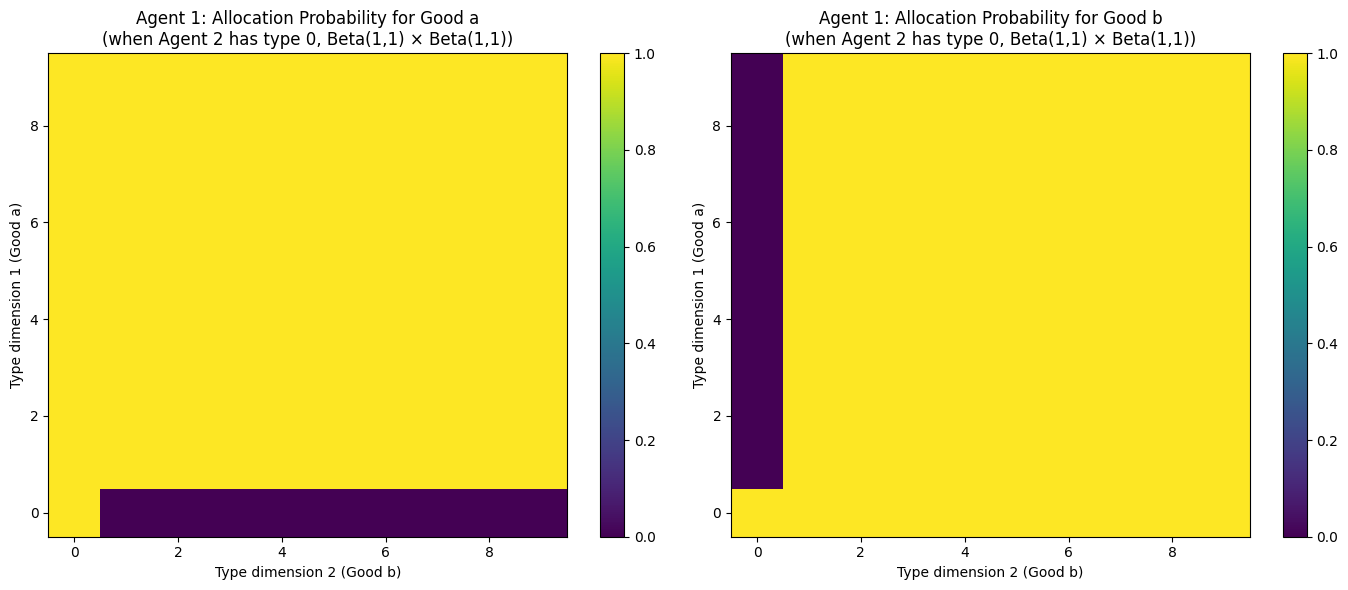

In [12]:
# 保存されたデータから読み込んで可視化
data = load_results_symmetry_2agents("data/results_symmetry_case1.npz")
print(f"Loaded data: J1={data['J1']}, J2={data['J2']}, obj_val={data['obj_val']}")
print(f"Grid sizes: {data.get('grid_sizes1', 'N/A')}, {data.get('grid_sizes2', 'N/A')}")
print(f"Number of iterations: {data.get('n_iter', 'N/A')}")
print(f"対称性確認: u1 == u2: {np.allclose(data['u1_sol'], data['u2_sol'])}")
print(f"対称性確認: p1 == p2: {np.allclose(data['p1_sol'], data['p2_sol'])}")

# 結果の可視化: エージェント1の配分確率（財a, 財b）
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# エージェント1が型j1で、エージェント2が型j2=0（最初の型）のときの配分確率
j2_example = 0
p1_a_slice = data['p1_sol'][0, :, j2_example]  # 財aの配分確率
p1_b_slice = data['p1_sol'][1, :, j2_example]  # 財bの配分確率

# エージェント1の型空間を2Dグリッドに再構成
NX1, NY1 = data['grid_sizes1']
p1_a_grid = p1_a_slice.reshape(NX1, NY1)
p1_b_grid = p1_b_slice.reshape(NX1, NY1)

# 財aの配分確率
im1 = axes[0].imshow(p1_a_grid, origin='lower', aspect='auto', cmap='viridis')
axes[0].set_title(f'Agent 1: Allocation Probability for Good a\n(when Agent 2 has type {j2_example}, Beta(1,1) × Beta(1,1))')
axes[0].set_xlabel('Type dimension 2 (Good b)')
axes[0].set_ylabel('Type dimension 1 (Good a)')
plt.colorbar(im1, ax=axes[0])

# 財bの配分確率
im2 = axes[1].imshow(p1_b_grid, origin='lower', aspect='auto', cmap='viridis')
axes[1].set_title(f'Agent 1: Allocation Probability for Good b\n(when Agent 2 has type {j2_example}, Beta(1,1) × Beta(1,1))')
axes[1].set_xlabel('Type dimension 2 (Good b)')
axes[1].set_ylabel('Type dimension 1 (Good a)')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()
